## 고령인구를 위한 공공와이파이 최적 입지 선정
### 공공와이파이를 우선 설치해야 하는 법정동 색출

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import pandas_profiling

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import warnings
warnings.filterwarnings(action='ignore') 


In [6]:
# QGIS로 데이터를 병합하여 저장한 결과, 아무리 인코딩을 맞춰보아도 문제가 해결이 안됨. 

data = pd.read_csv(r'D:\NIA\선택과제\Selecting-the-best-location-for-public-Wi-Fi\최종취합데이터_법정동.csv', encoding = 'utf-8-sig')

data.rename(columns = {'법정동�' : '법정동코드','총인구�' : '총인구수',
             '공공와�' : '공공와이파이수','고령인�' : '고령인구수',
                       '기초생�' : '기초생활인구수',
             '평균소�' : '평균소득','프렌차�' : '프렌차이즈수',
             '법정동�_1' : '법정동명'
                      }, inplace = True)

data.head()

,법정동코드,총인구수,공공와이파이수,고령인구수,기초생활인구수,평균소득,프렌차이즈수,법정동명,일반인구비율,고령인구비율,기초생활수급자비율,정보화수준_역량
0,4377033023,231.0,0.0,102.0,2,2112.63,0.0,마산리,0.549784,0.441558,0.008658,0.794909
1,4377032030,295.0,0.0,152.0,1,1737.02,0.0,문암리,0.481356,0.515254,0.003390,0.761183
2,4377034026,302.0,0.0,108.0,1,1473.06,0.0,수태리,0.639073,0.357616,0.003311,0.834175
3,4377031027,285.0,1.0,139.0,1,2185.76,0.0,금고리,0.508772,0.487719,0.003509,0.773923
4,4377025029,3602.0,5.0,809.0,1,3564.58,3.0,신천리,0.775125,0.224597,0.000278,0.895991


In [14]:
data.filter(regex='비율')

,일반인구비율,고령인구비율,기초생활수급자비율
0,0.549784,0.441558,0.008658
1,0.481356,0.515254,0.003390
2,0.639073,0.357616,0.003311
3,0.508772,0.487719,0.003509
4,0.775125,0.224597,0.000278
...,...,...,...
110,0.519380,0.480620,0.000000
111,0.582938,0.417062,0.000000
112,0.569721,0.426295,0.003984
113,0.736842,0.210526,0.052632


### 전체 변수 상관관계 시각화

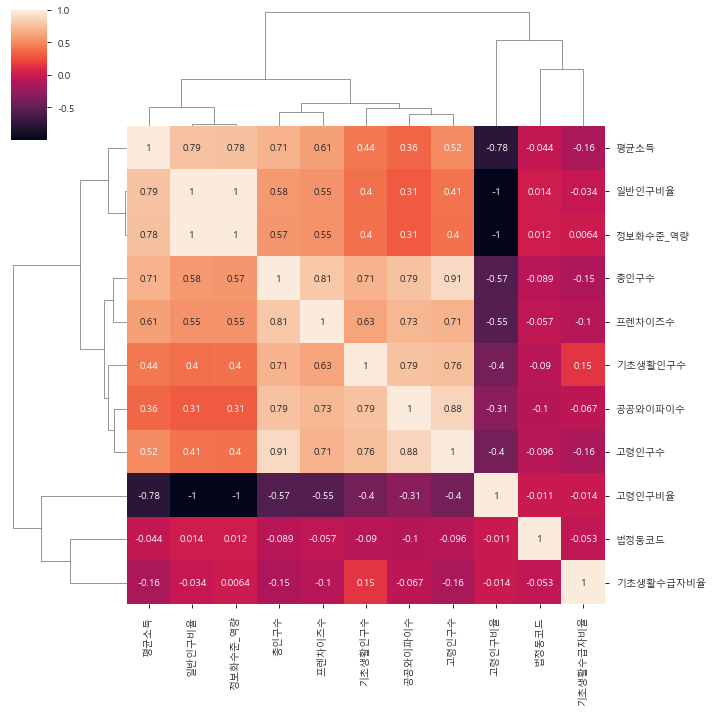

In [15]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


sns.clustermap(pd.DataFrame(data, columns = data.columns).corr(), annot = True)

### 적은 고령인구가 존재하는 지역 필터링

In [16]:
고령_25 = np.quantile(data['고령인구수'], 0.25)
print(f' 하위 25%의 고령인구수 : {고령_25}')

data.sort_values(by = '고령인구수')

 하위 25%의 고령인구수 : 86.0


,법정동코드,총인구수,공공와이파이수,고령인구수,기초생활인구수,평균소득,프렌차이즈수,법정동명,일반인구비율,고령인구비율,기초생활수급자비율,정보화수준_역량
113,4377033030,19.0,1.0,4.0,1,1701.22,0.0,군자리,0.736842,0.210526,0.052632,0.898579
66,4377025325,67.0,0.0,28.0,1,1832.39,0.0,백야리,0.567164,0.417910,0.014925,0.805388
88,4377036023,151.0,0.0,49.0,1,1787.73,1.0,도신리,0.668874,0.324503,0.006623,0.849258
80,4377036030,107.0,4.0,50.0,0,1616.03,0.0,차곡리,0.532710,0.467290,0.000000,0.783645
7,4377034028,142.0,0.0,55.0,0,1521.62,0.0,미곡리,0.612676,0.387324,0.000000,0.820669
...,...,...,...,...,...,...,...,...,...,...,...,...
18,4377035021,3325.0,12.0,781.0,4,2993.14,12.0,덕정리,0.763910,0.234887,0.001203,0.891157
4,4377025029,3602.0,5.0,809.0,1,3564.58,3.0,신천리,0.775125,0.224597,0.000278,0.895991
81,4377037021,5004.0,5.0,983.0,3,3296.18,4.0,오향리,0.802958,0.196443,0.000600,0.909002
85,4377025321,9244.0,35.0,1542.0,7,3269.70,49.0,무극리,0.832432,0.166811,0.000757,0.922710


In [17]:
data_new = data[data['고령인구수'] > np.quantile(data['고령인구수'], 0.25)].reset_index()

In [8]:
#!pip install pandas_profiling
features = ['기초생활수급자비율',
            '정보화수준_역량','평균소득','프렌차이즈수', '고령인구비율']

In [9]:
data_new = data_new[features]

### 데이터 프로파일링

In [10]:
pr=data_new.profile_report()


pr.to_widgets()

### 특정 변수만을 이용

In [40]:
data_new

,기초생활수급자비율,정보화수준_역량,평균소득,프렌차이즈수,고령인구비율
0,0.008658,0.794909,2112.63,0.0,0.441558
1,0.003390,0.761183,1737.02,0.0,0.515254
2,0.003311,0.834175,1473.06,0.0,0.357616
3,0.003509,0.773923,2185.76,0.0,0.487719
4,0.000278,0.895991,3564.58,3.0,0.224597
...,...,...,...,...,...
79,0.000000,0.764736,1743.28,0.0,0.508130
80,0.002506,0.825752,1932.11,1.0,0.375940
81,0.000000,0.806900,1672.74,0.0,0.417062
82,0.003984,0.802327,1833.35,0.0,0.426295


### PCA

In [11]:
scaler = StandardScaler().fit_transform(data_new) # 스케일링

from sklearn.decomposition import PCA

pca = PCA(n_components=5) # 주성분 5개로 설정

printcipalComponents = pca.fit_transform(scaler)
pca_data = pd.DataFrame(data=printcipalComponents, columns = ['PC1', 'PC2','PC3','PC4','PC5'])

pca.explained_variance_ # eigen vactor

print(pca_data) 
# PC score 
# X의 자료에 eigen vector를 곱한 값, 새로운 공간에서 좌표값으로 나타남

print('------------------------')

print(f'각 주성분의 분산 설명량 비율\n{pca.explained_variance_ratio_}') 
#각 주성분의 분산 설명량 비율 = 각 주성분의 고윳값이 차지하는 비율


         PC1       PC2       PC3       PC4           PC5
0  -1.200516  2.097935 -0.106738  0.395977  2.464612e-09
1  -1.726992  0.083224  0.395997  0.334148  7.373633e-10
2  -0.514463  0.285344 -0.367576 -0.850850  3.097459e-09
3  -1.206668  0.204459  0.210540  0.672792 -1.701417e-09
4   2.343651 -0.366604 -0.851392  0.596552  3.668699e-09
..       ...       ...       ...       ...           ...
79 -1.430340 -1.106912  0.420723  0.257635 -5.358376e-09
80 -0.275789  0.022768 -0.194025 -0.272200  6.182220e-09
81 -0.680353 -0.967611 -0.029445 -0.336286 -6.728391e-10
82 -0.928733  0.442987 -0.071052 -0.056849 -1.334034e-09
83 -1.399277  0.839167  0.108782  0.116869  1.075796e-09

[84 rows x 5 columns]
------------------------
각 주성분의 분산 설명량 비율
[6.48342515e-01 1.84275118e-01 1.19426106e-01 4.79562598e-02
 2.81228953e-18]


* PCA 요소

In [12]:
print(pca.components_.T) # loadings
print('------------------------')
print(pca.explained_variance_ratio_) #각 주성분의 분산 설명량 비율 = 각 주성분의 고윳값이 차지하는 비율

[[-1.85973974e-01  9.80645677e-01 -5.09752900e-02  3.37998505e-02
   2.61275992e-03]
 [ 5.29320208e-01  9.45335988e-02 -3.04054034e-01 -3.43542590e-01
   7.07398862e-01]
 [ 5.01649957e-01  6.14369427e-02 -7.84982299e-02  8.59308356e-01
  -7.48974175e-11]
 [ 3.91997327e-01  1.26381842e-01  8.97815652e-01 -1.55861415e-01
  -2.59615375e-11]
 [-5.29073922e-01 -9.82373996e-02  3.04495890e-01  3.43703982e-01
   7.06809751e-01]]
------------------------
[6.48342515e-01 1.84275118e-01 1.19426106e-01 4.79562598e-02
 2.81228953e-18]


* elbow plot

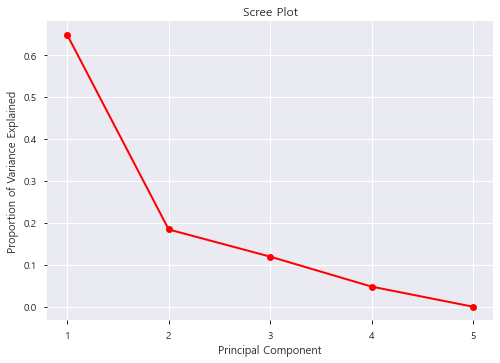

In [60]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(np.arange(1,6))
plt.show()

-- 주성분개수는 2개로 결정

* matplotlib rcParams요소 확인

In [104]:
import matplotlib 

Artists = set()
for key in matplotlib.rcParams.keys():
    if "." in key:
        Artists .add(key.split(".")[0])

print(Artists)

{'boxplot', 'figure', 'pgf', 'webagg', 'patch', 'ytick', 'animation', 'pdf', 'docstring', 'date', 'contour', 'polaraxes', 'ps', 'font', 'tk', 'scatter', '_internal', 'image', 'keymap', 'mpl_toolkits', 'yaxis', 'savefig', 'agg', 'hist', 'lines', 'text', 'xtick', 'grid', 'legend', 'markers', 'pcolor', 'errorbar', 'mathtext', 'path', 'xaxis', 'axes3d', 'svg', 'hatch', 'axes'}


* biplot 함수 생성

In [115]:
def biplot(score,coeff,y=None,labels=None):
    xs = score[:,0] # projection of PC1
    ys = score[:,1] # projection of PC2
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    
    
    # aggiungo frecce
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5,
                 head_width = 0.02, width = 0.005)
        if labels is None:
            plt.text(coeff[i,0]+0.01, coeff[i,1]+0.01, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]+0.01, coeff[i,1]+0.01, labels[i], color = 'g', ha = 'center', va = 'center')

    # aggiungo flag outliers
    for i in range(len(xs)):
        if ((xs[i]>np.quantile(xs,0.99)) | (ys[i]>np.quantile(xs,0.99))):
            plt.text(xs[i] * scalex,ys[i] * scaley, str(i), size = 20)

            
            
            

    # etichette
    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    plt.grid = True
    plt.tick_params(axis='both', which='both', labelsize=14)
    plt.tight_layout()


In [117]:
plt.style.use('default')

Text(0.5, 1.0, '주성분분석')

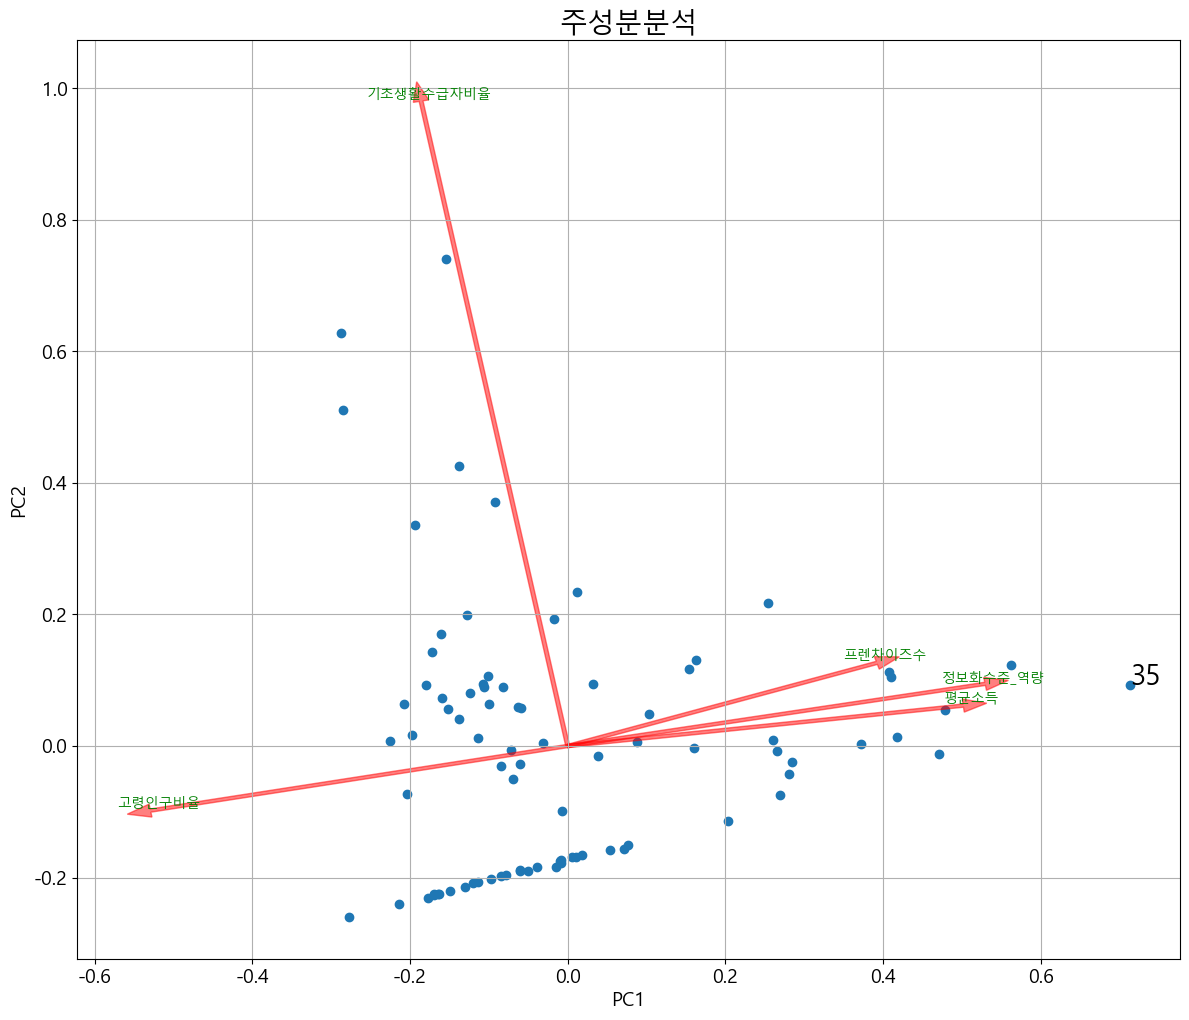

In [126]:
plt.figure(figsize=(12,10))

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['axes.grid'] = True
#plt.rcParams['axes.edgecolor'] = "black"

biplot(score=printcipalComponents,coeff=np.transpose(pca.components_),labels= features)
plt.title('주성분분석', fontsize = 20)


In [39]:
# PC1 : 값이 클수록 고령인구비율이 적고 잘 사는 지역
# PC2 : 값이 클수록 기초수급자비율이 높은 지역

### 그룹이름을 a, b , c로 나타냄.
#### 우선지역은 a < b < c 순이다.

### K-means

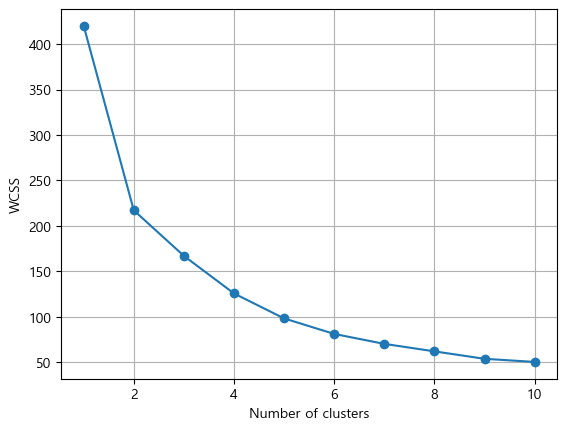

In [127]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(pca_data)
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [129]:
pca_raw = pca_data[['PC1','PC2']]

In [89]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
k_means.fit(pca_raw)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

In [90]:
pca_data['kmeans_cluster'] = k_means.labels_

Text(0.5, 1.0, 'K-means')

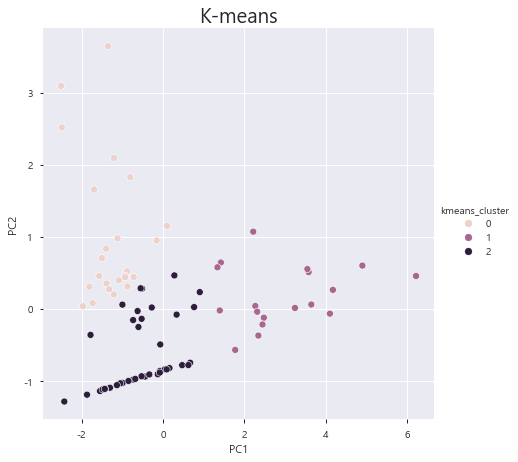

In [91]:
sns.relplot(
    x="PC1", y="PC2", hue="kmeans_cluster", 
    data=pca_data, height=6,
);
plt.title('K-means', size = 20)

In [45]:
pca_data.groupby('kmeans_cluster')[['PC1','PC2']].mean()

# PC1 : 값이 클수록 고령인구비율이 적고 잘 사는 지역
# PC2 : 값이 클수록 기초수급자비율이 높은 지역


,PC1,PC2
kmeans_cluster,,
0,-0.915937,1.303739
1,-0.650582,-0.546740
2,3.135088,0.166254


In [92]:
pca_data.kmeans_cluster[pca_data.kmeans_cluster == 0] = 'c'
pca_data.kmeans_cluster[pca_data.kmeans_cluster == 1] = 'a'
pca_data.kmeans_cluster[pca_data.kmeans_cluster == 2] = 'b'

In [93]:
pca_data

,PC1,PC2,PC3,PC4,PC5,kmeans_cluster
0,-1.200516,2.097935,-0.106738,0.395977,2.464612e-09,c
1,-1.726992,0.083224,0.395997,0.334148,7.373633e-10,c
2,-0.514463,0.285344,-0.367576,-0.850850,3.097459e-09,b
3,-1.206668,0.204459,0.210540,0.672792,-1.701417e-09,c
4,2.343651,-0.366604,-0.851392,0.596552,3.668699e-09,a
...,...,...,...,...,...,...
79,-1.430340,-1.106912,0.420723,0.257635,-5.358376e-09,b
80,-0.275789,0.022768,-0.194025,-0.272200,6.182220e-09,b
81,-0.680353,-0.967611,-0.029445,-0.336286,-6.728391e-10,b
82,-0.928733,0.442987,-0.071052,-0.056849,-1.334034e-09,c


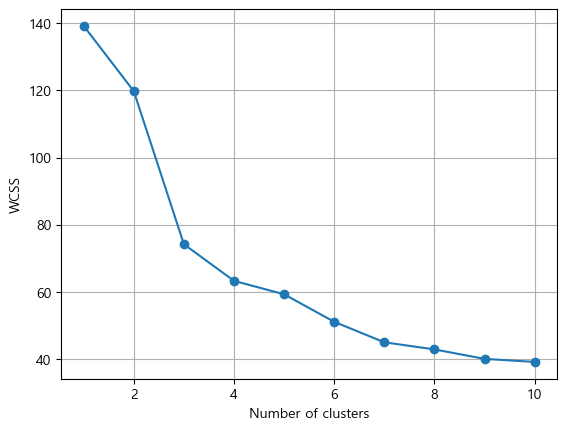

In [131]:
WCSS = []
for i in range(1, 11):
    km = KMedoids(
        n_clusters=i
    )
    km.fit(pca_raw)
    WCSS.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [95]:
kmedoids = KMedoids(n_clusters=3, random_state=0).fit(pca_raw)
pca_data['kmedoids_cluster'] = kmedoids.labels_    

Text(0.5, 1.0, 'K-medoids')

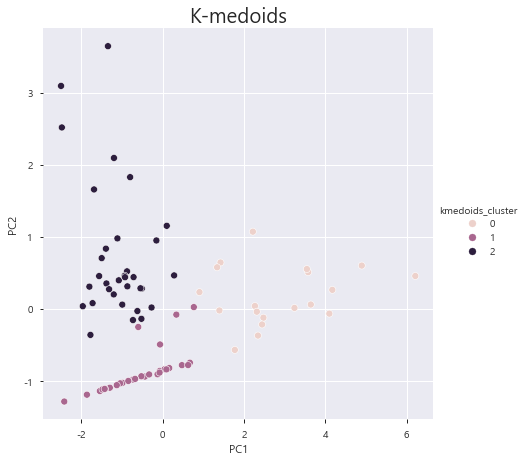

In [96]:
sns.relplot(
    x="PC1", y="PC2", hue="kmedoids_cluster", 
    data=pca_data, height=6,
);
plt.title('K-medoids', size = 20)

In [97]:
pca_data.groupby('kmedoids_cluster')[['PC1','PC2']].mean()

# PC1 : 값이 클수록 고령인구비율이 적고 잘 사는 지역
# PC2 : 값이 클수록 기초수급자비율이 높은 지역

# 0 : 고령인구비율이 높고 못 사는 지역
# 1 : 잘 사는 지역
# 2 : 어정쩡한 지역

,PC1,PC2
kmedoids_cluster,,
0,2.858139,0.194113
1,-0.565157,-0.874056
2,-1.097564,0.735808


In [98]:
pca_data.kmedoids_cluster[pca_data.kmedoids_cluster == 0] = 'a'
pca_data.kmedoids_cluster[pca_data.kmedoids_cluster == 1] = 'b'
pca_data.kmedoids_cluster[pca_data.kmedoids_cluster == 2] = 'c'

In [99]:
len(pca_data[pca_data.kmedoids_cluster == 'c'])

33

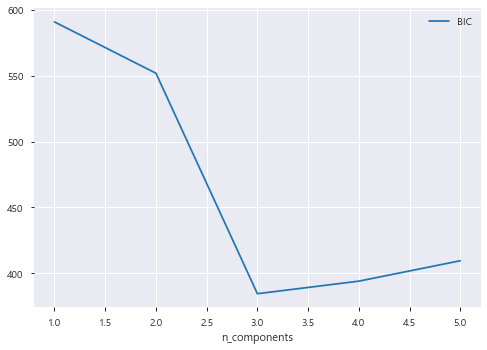

In [100]:
n_components = np.arange(1, 6)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(pca_raw)
          for n in n_components]

plt.plot(n_components, [m.bic(pca_raw) for m in models], label='BIC')
#plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [101]:
# GMM 적용

# n_components로 미리 군집 개수 설정
gmm = GaussianMixture(n_components=3, random_state=40)
gmm_labels = gmm.fit(pca_raw).predict(pca_raw)

pca_data['gmm_cluster'] = gmm_labels

Text(0.5, 1.0, 'GMM')

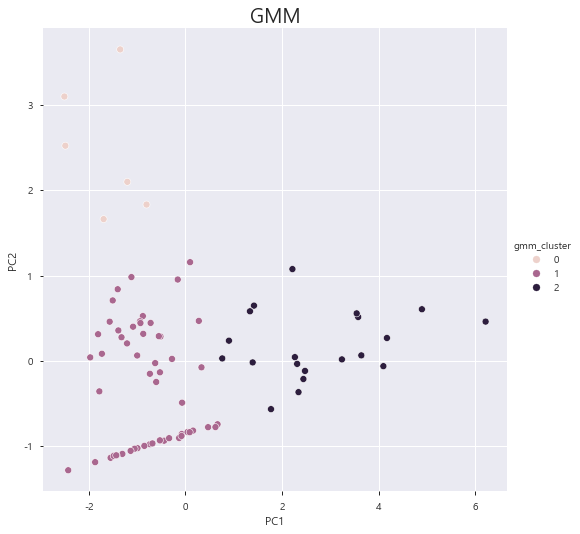

In [102]:
sns.relplot(
    x="PC1", y="PC2", hue="gmm_cluster", 
    data=pca_data, height=7,
);
plt.title('GMM', size = 20)

In [103]:
pca_data.groupby('gmm_cluster')[['PC1','PC2']].mean()

# PC1 : 값이 클수록 고령인구비율이 적고 잘 사는 지역
# PC2 : 값이 클수록 기초수급자비율이 높은 지역

# 0 : 어정쩡한 지역
# 1 : 잘 사는 지역
# 2 : 못 사는 지역

,PC1,PC2
gmm_cluster,,
0,-1.671713,2.476605
1,-0.776537,-0.320281
2,2.753471,0.185834


In [104]:
pca_data.gmm_cluster[pca_data.gmm_cluster == 0] = 'c'
pca_data.gmm_cluster[pca_data.gmm_cluster == 1] = 'b'
pca_data.gmm_cluster[pca_data.gmm_cluster == 2] = 'a'


In [105]:
#pca_data = pca_data.reset_index().drop(['합산','score','index'] , axis = 1)

In [106]:
pca_data1 = pca_data

In [107]:
cluster = pca_data1.iloc[:,5:]
cluster.replace({'a':0, 'b':1,'c':2}, inplace = True)

cluster.head()

,kmeans_cluster,kmedoids_cluster,gmm_cluster
0,2,2,2
1,2,2,1
2,1,2,1
3,2,2,1
4,0,0,0


### 점수화를 이용한 도출

In [108]:
pca_data1['합산'] = cluster.sum(axis = 1)

In [109]:
pca_data1

,PC1,PC2,PC3,PC4,PC5,kmeans_cluster,kmedoids_cluster,gmm_cluster,합산
0,-1.200516,2.097935,-0.106738,0.395977,2.464612e-09,c,c,c,6
1,-1.726992,0.083224,0.395997,0.334148,7.373633e-10,c,c,b,5
2,-0.514463,0.285344,-0.367576,-0.850850,3.097459e-09,b,c,b,4
3,-1.206668,0.204459,0.210540,0.672792,-1.701417e-09,c,c,b,5
4,2.343651,-0.366604,-0.851392,0.596552,3.668699e-09,a,a,a,0
...,...,...,...,...,...,...,...,...,...
79,-1.430340,-1.106912,0.420723,0.257635,-5.358376e-09,b,b,b,3
80,-0.275789,0.022768,-0.194025,-0.272200,6.182220e-09,b,c,b,4
81,-0.680353,-0.967611,-0.029445,-0.336286,-6.728391e-10,b,b,b,3
82,-0.928733,0.442987,-0.071052,-0.056849,-1.334034e-09,c,c,b,5


In [110]:
pca_data1['score'] = pca_data1['합산'] * data['고령인구수'] * data['고령인구비율']

In [111]:
pca_data1['고령인구수'] = data['고령인구수']
pca_data1['총인구수'] = data['총인구수']

* 점수가 5점 이상인 데이터만을 추출

In [113]:
final = pca_data.sort_values('score', ascending = False)
final.index = data['법정동명']

ff = final.loc[final.합산 >= 5]

In [296]:
ff

,PC1,PC2,PC3,PC4,PC5,kmeans_cluster,kmedoids_cluster,gmm_cluster,합산,score,고령인구수,총인구수
법정동명,,,,,,,,,,,,
마산리,-1.805764,0.312150,0.392873,0.303667,5.421655e-09,2,2,1,5,658.147773,255.0,494.0
수태리,-1.565798,0.459039,0.213386,-0.007612,-2.396453e-09,2,2,1,5,532.224622,222.0,463.0
금고리,-1.968306,0.040673,0.583147,0.770782,-7.017889e-09,2,2,1,5,453.395904,163.0,293.0
신천리,-1.726992,0.083224,0.395997,0.334148,7.373633e-10,2,2,1,5,391.593220,152.0,295.0
병암리,-1.206668,0.204459,0.210540,0.672792,-1.701417e-09,2,2,1,5,338.964912,139.0,285.0
한벌리,-1.115573,0.981776,-0.065091,-0.055539,-3.500347e-09,2,2,1,5,337.063712,156.0,361.0
본대리,-1.386141,0.356432,0.254803,0.599610,-2.104910e-10,2,2,1,5,307.520000,124.0,250.0
봉현리,-1.320794,0.276285,0.151819,0.105745,-1.677938e-09,2,2,1,5,295.092937,126.0,269.0
덕정리,0.098789,1.156429,-0.303118,-0.656143,3.137419e-09,2,2,1,5,283.398926,178.0,559.0


In [114]:
len(ff)

24

Text(0.5, 1.0, 'Cluster')

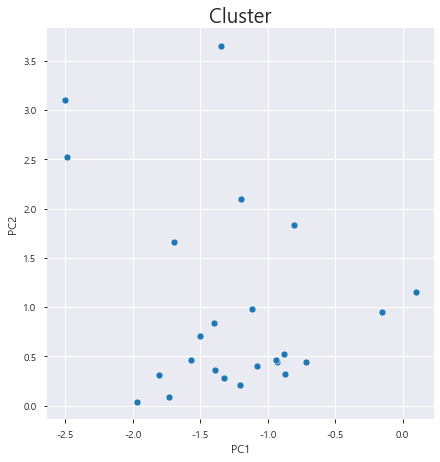

In [115]:
sns.relplot(
    x="PC1", y="PC2", 
    data=ff, height=6,palette='Set2',
);
plt.title('Cluster', fontsize = 20)

In [116]:
ff.to_csv(r"D:\NIA\선택과제\충청북도 음성군 공공와이파이 우선설치지역 도출\final.csv")

### 최빈값을 이용한 도출

In [117]:
# 최빈값 구하기

mode_list = []

for i in range(len(cluster)):
    vals,counts = np.unique(cluster.iloc[i,:], return_counts=True)
    index = np.argmax(counts)
    mode_list.append(vals[index])
    #print(mode_list)

In [118]:
pca_data['final_cluster'] = mode_list
pca_data['final_cluster'] = pca_data['final_cluster'].astype('category')


Text(0.5, 1.0, 'Voting_Cluster')

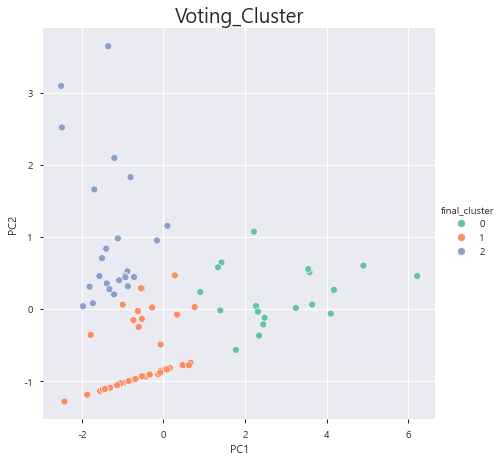

In [119]:
sns.relplot(
    x="PC1", y="PC2", 
    hue="final_cluster", markers='final_cluster', 
    data=pca_data, height=6, palette='Set2',
);
plt.title('Voting_Cluster', fontsize = 20)

In [120]:
pca_data['final_cluster'].value_counts()

1    41
2    24
0    19
Name: final_cluster, dtype: int64

#### 상의 결과, K-medoids을 이용해 나온 군집을 저장

In [ ]:
data['kmedoids'] = pca_data['kmedoids_cluster']
data.head()

dk = data[data.kmedoids == 2]
dk.to_csv(r"D:\NIA\선택과제\충청북도 음성군 공공와이파이 우선설치지역 도출\음성군_법정동데이터(완벽)\kmedodis.csv", index = False, encoding = 'utf-8-sig')